<a href="https://colab.research.google.com/github/sesha-2k3/Simple-Recurrent-Neural-Network/blob/main/RNN_(LSTM)_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RNN for Bitcoin Price Prediction

### Loading the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM

### Loading the Dataset

In [ ]:
data = pd.read_csv('/content/btcedge.csv')

In [ ]:
# Summarize the data
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [ ]:
# No. of rows and columns of the dataset
data.shape

(627190, 14)

In [ ]:
data['rpt_key'].value_counts()

btc_usd       125438
btc_eur        62719
btc_jpy        62719
btc_krw        62719
etc_krw        62719
eth_btc        62719
eth_krw        62719
fx_btc_jpy     62719
ltc_usd        62719
Name: rpt_key, dtype: int64

In [ ]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


### Convert datetime_id to data type and filter dates greater than 2017-06-28 00:00:00

In [ ]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [ ]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


### Last value is the target variable so we subset it and store it in a numpy array

In [ ]:
dataset = df[['last']].values
dataset = dataset.astype('float64')
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]])

### Feature Scaling

In [ ]:
# Scaling the data in the range of 0 - 1
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.19976947],
       [0.49828066],
       [0.18666795],
       ...,
       [0.29587936],
       [0.15456728],
       [0.29587936]])

### Splitting the data into test and train set

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


### Function to create input and output arrays

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [ ]:
trainX

array([[0.19976947, 0.49828066, 0.18666795, ..., 0.49753146, 0.19973105,
        0.48600519],
       [0.49828066, 0.18666795, 0.48554414, ..., 0.19973105, 0.48600519,
        0.18442032],
       [0.18666795, 0.48554414, 0.18251849, ..., 0.48600519, 0.18442032,
        0.48598598],
       ...,
       [0.53376237, 0.69436173, 0.53105369, ..., 0.70821247, 0.520584  ,
        0.70815484],
       [0.69436173, 0.53105369, 0.70823168, ..., 0.520584  , 0.70815484,
        0.5266545 ],
       [0.53105369, 0.70823168, 0.53320526, ..., 0.70815484, 0.5266545 ,
        0.70815484]])

In [ ]:
trainY

array([0.18442032, 0.48598598, 0.19208529, ..., 0.5266545 , 0.70815484,
       0.52064163])

In [ ]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX

array([[[0.19976947, 0.49828066, 0.18666795, ..., 0.49753146,
         0.19973105, 0.48600519]],

       [[0.49828066, 0.18666795, 0.48554414, ..., 0.19973105,
         0.48600519, 0.18442032]],

       [[0.18666795, 0.48554414, 0.18251849, ..., 0.48600519,
         0.18442032, 0.48598598]],

       ...,

       [[0.53376237, 0.69436173, 0.53105369, ..., 0.70821247,
         0.520584  , 0.70815484]],

       [[0.69436173, 0.53105369, 0.70823168, ..., 0.520584  ,
         0.70815484, 0.5266545 ]],

       [[0.53105369, 0.70823168, 0.53320526, ..., 0.70815484,
         0.5266545 , 0.70815484]]])

In [ ]:
testX

array([[[0.52308136, 0.70805878, 0.52062242, ..., 0.71937374,
         0.52513687, 0.72214004]],

       [[0.70805878, 0.52062242, 0.70807799, ..., 0.52513687,
         0.72214004, 0.52673134]],

       [[0.52062242, 0.70807799, 0.52062242, ..., 0.72214004,
         0.52673134, 0.72713476]],

       ...,

       [[0.15854385, 0.29065412, 0.15854385, ..., 0.31833637,
         0.15856306, 0.29587936]],

       [[0.29065412, 0.15854385, 0.31833637, ..., 0.15856306,
         0.29587936, 0.15456728]],

       [[0.15854385, 0.31833637, 0.15408702, ..., 0.29587936,
         0.15456728, 0.29587936]]])

## Building the Model

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=1)

Epoch 1/100
125/125 [==============================] - 3s 3ms/step - loss: 0.1766 - acc: 3.1318e-05
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0063 - acc: 1.2527e-04
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0050 - acc: 1.2527e-04
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0041 - acc: 1.2527e-04
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0032 - acc: 1.2527e-04
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0024 - acc: 1.2527e-04
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 1.2527e-04
Epoch 8/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0011 - acc: 1.2527e-04
Epoch 9/100
125/125 [==============================] - 1s 4ms/step - loss: 7.4527e-04 - acc: 1.2527e-04
Epoch 10/100
125/125 [==============================] - 1s 4ms/step - loss: 4.7463e-04 - acc: 1.

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

492/492 [==============================] - 1s 2ms/step


In [ ]:
# Reversing the data 
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# Evaluation Scores
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'Train Score: {trainScore} RMSE')
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print(f'Test Score: {testScore} RMSE')
print(f'R2 Score on Training Data: {r2_score(trainY[0], trainPredict[:, 0])}')
print(f'R2 Score on Test Data: {r2_score(testY[0], testPredict[:, 0])}')

Train Score: 4.892282941699478 RMSE
Test Score: 7.614420040006575 RMSE
R2 Score on Training Data: 0.9959513296321189
R2 Score on Test Data: 0.9941789879580278


In [ ]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

In [ ]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 

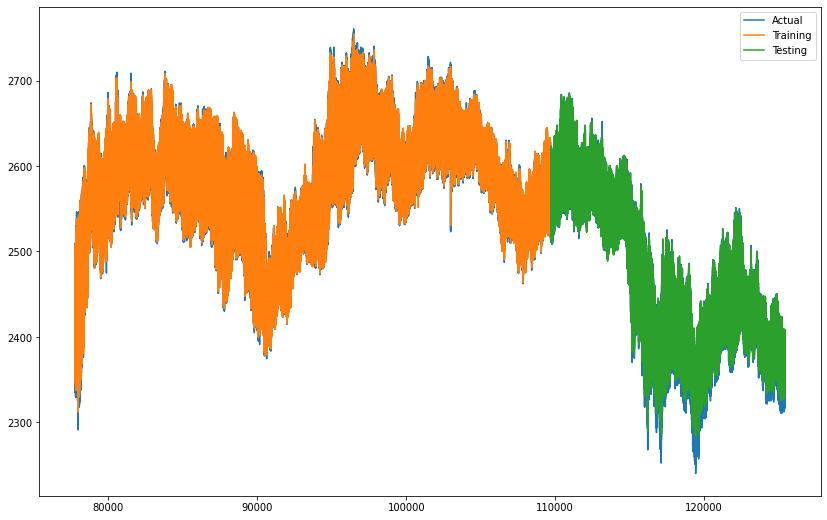

In [ ]:
plt.figure(figsize=(14,9))
plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()